# Misbehavior Detection in Vehicular Networks with Federated Learning

## Imports

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import locale
import flwr as fl
import numpy as np
import pandas as pd
from abc import ABC
from metrics import *
import seaborn as sns
import tensorflow as tf
from itertools import cycle
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils import shuffle
from typing import Optional, Tuple, Dict, Any
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, auc
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, roc_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.set_visible_devices(physical_devices[1:], 'GPU')
  logical_devices = tf.config.list_logical_devices('GPU')
  assert len(logical_devices) == len(physical_devices) - 1
except:
  pass

tf.get_logger().setLevel('ERROR')
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
locale._override_localeconv = {'thousands_sep': '.'}

from IPython.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

## Support Functions

In [3]:
def load_veremi(csv_file: str, feature: str, label: str, delimiter=','):
    # Import VeReMi Dataset
    data = pd.read_csv(csv_file, delimiter=delimiter)

    # select columns
    columns = []
    for column in data.columns.values:
        if feature == 'feat1':
            if 'RSSI' in column:
                columns.append(column)
            elif 'distance' in column:
                columns.append(column)
        elif feature == 'feat2':
            if 'conformity' in column and '0' not in column:
                columns.append(column)
        elif feature == 'feat3':
            if 'RSSI' in column and '0' not in column:
                columns.append(column)
            elif 'distance' in column and '0' not in column:
                columns.append(column)
            elif 'conformity' in column and '0' not in column:
                columns.append(column)
        elif feature == 'feat4':
            if 'RSSI' in column:
                columns.append(column)
            elif 'aoa' in column:
                columns.append(column)
            elif 'distance' in column:
                columns.append(column)
            elif 'conformity' in column and '0' not in column:
                columns.append(column)
    columns.append('attackerType')

    # process target values
    if label == 'multiclass':
        data = data[columns]
    elif label == 'binary':
        pos_label = 1
        data = data[columns]
        data['attackerType'].loc[data['attackerType'] != 0] = pos_label
    else:
        pos_label = int(label.split("_")[1])
        data = data[columns]
        data = data.loc[(data['attackerType'] == 0) | (data['attackerType'] == pos_label)]

    data_normal = data.loc[data['attackerType'] == 0]
    data_atk = data.loc[data['attackerType'] != 0]
    # atk_size = int(data_atk.shape[0] * 1.5)
    atk_size = int(data_atk.shape[0])
    data = pd.concat([data_normal.sample(atk_size), data_atk])
    data = shuffle(data)

    dataset = data
    target = data[data.columns[-1:]]
    data = data[data.columns[0:-1]]

    # normalize data
    data = (data - data.mean()) / data.std()

    # label binarize one-hot style
    lb = preprocessing.LabelBinarizer()
    lb.fit(target)
    if label == 'multiclass':
        target = lb.transform(target)
    else:
        target = lb.transform(target)
        target = MultiLabelBinarizer().fit_transform(target)

    # Create training and test data
    train_data, test_data, train_labels, test_labels = train_test_split(
        data,
        target,
        train_size=Config.data_train_size,
        test_size=Config.data_test_size,
        # random_state=42
    )

    return train_data, test_data, train_labels, test_labels, lb, dataset

## Config Class

In [4]:
class Config:
    csv = "../dismiss-bsm-globecom2022-main/models/globecom/dismiss/02bsm/preprocessing/allmsg/allMsg-new-preds.csv"
    model_type = "mlp"
    label = "multiclass"
    feature = "feat4"
    batch_size = 128
    epochs = 50
    rounds = 80
    learning_rate = 3e-4 #1e-3
    min_available_clients = 2
    fraction_fit = 0.1
    early_stop_patience = 3
    early_stop_monitor = "loss"
    early_stop_min_delta = 1e-4
    early_stop_restore_best_weights = True
    data_train_size = 0.8
    data_test_size = 0.2
    output_path = f"results/{feature}/{label}/"
    performance_file = "performance.csv"
    weights_file = "model_weights.npz"

## Metrics

In [5]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

## VeReMi Base Class

In [6]:
class VeremiBase(ABC):
    def __init__(self, data_file: str, model_type: str, label: str, feature: str, activation: str = "softmax"):
        """ The Veremi Client Constructor
            :param model_type: Keras Model Type ('mlp' or 'lstm'
            :param label: Model label type ('binary', 'multiclass', 'atk_1', 'atk_2', 'atk_4', 'atk_8', 'atk_16')
            :param feature: Feature to evaluate ('feat1', 'feat2', 'feat3')
        """
        self.lb = None
        self.dataset = None
        self.train_data = None
        self.test_data = None
        self.train_labels = None
        self.test_labels = None
        self.model = None
        self.data_file = data_file
        self.label = label
        self.feature = feature
        self.model_type = model_type
        self.activation = activation

        self.load_veremi()
        self.create_model()

    def create_model(self):
        layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8, layer9, output = \
            None, None, None, None, None, None, None, None, None, None
        if self.model_type == 'mlp':
            layer1 = keras.layers.Input(shape=(self.train_data.shape[1],))
            layer2 = keras.layers.Dense(256, activation="relu")(layer1)
            layer3 = keras.layers.Dense(256, activation="relu")(layer2)
            layer4 = keras.layers.Dropout(0.5)(layer3)
            output = keras.layers.Dense(self.train_labels.shape[1], activation=self.activation)(layer4)
        else:
            pass

        # ML Model
        name = self.label + "-" + self.model_type + "-" + self.feature
        self.model = keras.Model(inputs=layer1, outputs=output, name=name)
        self.model.compile(
            loss=keras.losses.CategoricalCrossentropy(),
            optimizer=keras.optimizers.Adam(learning_rate=Config.learning_rate),
            metrics=[f1]
        )
        self.model.summary()

    def load_veremi(self):
        print("Loading dataset in " + self.__class__.__name__ + "...")
        self.train_data, self.test_data, self.train_labels, self.test_labels, self.lb, self.dataset = load_veremi(
            self.data_file,
            feature=self.feature,
            label=self.label
        )

## VeReMi Client Class

In [7]:
class VeremiClient(VeremiBase, fl.client.NumPyClient):
    def __init__(self, data_file: str, model_type: str, label: str, feature: str):
        VeremiBase.__init__(self, data_file, model_type, label, feature)
        self.history = None

    def get_parameters(self, config):
        return self.model.get_weights()
    
    def fit(self, parameters, config, verbose):
        print("Training...")
        early_stopping = keras.callbacks.EarlyStopping(
            monitor=Config.early_stop_monitor,
            patience=Config.early_stop_patience,
            min_delta=Config.early_stop_min_delta,
            restore_best_weights=Config.early_stop_restore_best_weights
        )
        if parameters is not None:
            self.model.set_weights(parameters)
        self.history = self.model.fit(
            self.train_data,
            self.train_labels,
            batch_size=config["batch_size"],
            epochs=config["epochs"],
            # callbacks=[early_stopping],
            validation_data=(self.test_data, self.test_labels),
            verbose=verbose,
        )
        result = {
            "f1_score:": float(self.history.history['f1'][-1]),
            "f1_val": float(self.history.history['val_f1'][-1]),
        }
        print("Finished!")
        return self.model.get_weights(), len(self.train_data), result

### Create Client

In [8]:
client = VeremiClient(Config.csv, Config.model_type, Config.label, Config.feature)

Loading dataset in VeremiClient...
Model: "multiclass-mlp-feat4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 256)               2048      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 69,382
Trainable params: 69,382
Non-trainable params: 0
_________________________________________________________________


## VeReMi DataSet

In [30]:
client.dataset

,aoa0,aoa1,RSSI0,distance0,RSSI1,distance1,conformity1,attackerType
1002433,0.138260,0.152957,5.394733e-09,53.162378,4.120589e-08,54.912082,4.276343,0.0
1085519,0.063239,0.028495,8.316230e-09,244.250429,8.497413e-09,244.441396,1.629658,0.0
2250629,0.740756,0.625101,1.406403e-09,148.340674,3.034993e-09,162.209074,0.393618,0.0
433381,1.159103,1.066895,3.043372e-09,507.826810,4.145469e-09,442.220065,1.082238,0.0
1357341,0.727151,1.547215,1.954551e-09,433.274199,3.432482e-09,299.933505,193.769991,0.0
...,...,...,...,...,...,...,...,...
495080,0.147886,0.305241,5.322183e-09,194.581156,1.089669e-08,196.801445,0.369332,0.0
2431721,0.077762,1.112885,2.371038e-09,376.907880,3.573118e-09,420.532068,30.158390,0.0
710112,0.426267,0.447813,2.860802e-09,558.542740,3.496405e-09,492.008956,14.213322,0.0
991808,1.206235,1.239401,1.440438e-09,401.754144,1.340471e-08,254.636633,0.196537,0.0


In [10]:
client.train_data.describe()

,aoa0,aoa1,RSSI0,distance0,RSSI1,distance1,conformity1
count,793950.000000,793950.000000,793950.000000,793950.000000,793950.000000,793950.000000,793950.000000
mean,0.000217,0.000754,0.000859,-0.000906,0.000498,-0.000778,-0.000313
std,1.000023,1.000272,1.012868,0.998497,1.071826,0.998686,0.999941
min,-1.352462,-1.355454,-0.094098,-0.547932,-0.058071,-0.540818,-0.324825
25%,-0.946884,-0.954011,-0.092890,-0.428503,-0.057287,-0.424873,-0.324745
50%,-0.200205,-0.181305,-0.090278,-0.344394,-0.055654,-0.344246,-0.323539
75%,1.002203,0.992884,-0.082442,-0.197108,-0.050918,-0.204802,-0.296791
max,1.613994,1.614379,396.918037,6.754025,779.546138,6.724057,7.301259


<AxesSubplot: xlabel='aoa0', ylabel='aoa1'>

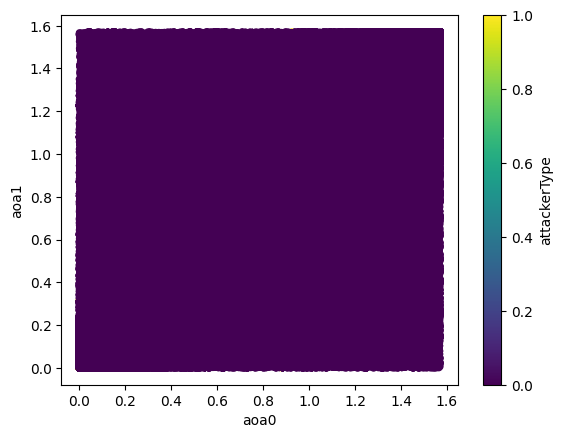

In [454]:
client.dataset.plot.scatter(x='aoa0', y='aoa1', c='attackerType', colormap='viridis')

In [31]:
attack = len(client.dataset[client.dataset.attackerType != 0])
normal = len(client.dataset[client.dataset.attackerType == 0])
total = attack + normal
print('Attackers:\n    Total: {:,d}\n    Attack: {:,d} ({:.2f}% of total)\n'.format(
    total, attack, 100 * attack / total))

Attackers:
    Total: 992,438
    Attack: 496,219 (50.00% of total)



In [12]:
atk_df = client.dataset.loc[client.dataset['attackerType'] != 0].sample(128)
normal_df = client.dataset.loc[client.dataset['attackerType'] == 0].sample(128)

# normalize data
columns = atk_df.columns[0:-1]
atk_df[columns] = (atk_df[columns] - atk_df[columns].mean()) / atk_df[columns].std()

columns = normal_df.columns[0:-1]
normal_df[columns] = (normal_df[columns] - normal_df[columns].mean()) / normal_df[columns].std()

atk_df

,aoa0,aoa1,RSSI0,distance0,RSSI1,distance1,conformity1,attackerType
971305,-0.595873,-0.604092,-0.139288,-0.472145,-0.227778,-0.475812,-0.453426,2.0
1312667,-0.815763,-0.644929,-0.141341,0.184232,-0.237442,1.737417,2.096229,4.0
901043,-0.743733,1.013438,-0.109856,-0.545921,-0.220559,-0.417239,-0.451197,2.0
309776,-0.832594,-0.753864,1.177272,-0.307935,0.330270,-0.306931,-0.452903,1.0
457617,-0.778091,-0.668504,-0.129908,0.251826,-0.204924,0.311376,-0.448471,1.0
...,...,...,...,...,...,...,...,...
1554467,1.514189,0.274243,-0.137460,-0.570573,-0.222941,-0.615905,-0.395816,8.0
1444396,1.748665,0.066308,-0.139043,0.841497,-0.211853,1.934713,1.391938,4.0
713431,-0.300315,-0.242710,11.062685,-0.524590,0.325845,-0.545510,-0.453056,2.0
1356880,0.074765,0.293578,-0.123397,2.632511,-0.192787,3.042495,3.408485,4.0


In [13]:
atk_df.describe()

,aoa0,aoa1,RSSI0,distance0,RSSI1,distance1,conformity1,attackerType
count,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,128.000000,128.000000,1.280000e+02,128.000000
mean,4.857226e-17,-6.938894e-17,-6.938894e-18,5.204170e-17,0.000000,0.000000,4.163336e-17,5.929688
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00,5.432744
min,-1.378752e+00,-1.356575e+00,-1.435830e-01,-6.581674e-01,-0.239196,-0.684918,-4.534258e-01,1.000000
25%,-8.135285e-01,-7.592344e-01,-1.394745e-01,-5.253949e-01,-0.235329,-0.566232,-4.512734e-01,2.000000
50%,-1.730955e-01,-2.399409e-01,-1.327856e-01,-4.132956e-01,-0.225323,-0.413719,-4.402093e-01,4.000000
75%,7.226010e-01,7.773163e-01,-1.148317e-01,-1.200326e-02,-0.204624,0.166655,-3.051479e-01,8.000000
max,1.922284e+00,2.019748e+00,1.106269e+01,3.703821e+00,7.323738,4.442400,4.281688e+00,16.000000


In [14]:
normal_df

,aoa0,aoa1,RSSI0,distance0,RSSI1,distance1,conformity1,attackerType
2074774,-1.483545,-1.526624,-0.276904,1.727279,-0.244672,1.728277,-0.202042,0.0
2313286,1.213163,1.237717,-0.134657,-1.011312,-0.239282,-0.230963,-0.221379,0.0
563557,-0.613088,-0.507789,-0.288871,-0.112390,-0.216478,-0.025133,-0.200195,0.0
1948676,-0.640919,-0.721677,-0.269738,-0.864862,-0.247231,-0.729553,-0.202100,0.0
1933294,0.861014,0.849481,0.141877,-1.161676,-0.166583,-1.014234,-0.165892,0.0
...,...,...,...,...,...,...,...,...
592623,1.206566,1.081213,-0.192866,-0.562665,-0.204714,-1.244263,-0.217526,0.0
615776,1.006325,0.881764,-0.240655,0.396043,-0.244815,0.404734,-0.221045,0.0
1696611,1.039258,1.067194,-0.231427,0.248086,-0.232031,0.255555,-0.213967,0.0
1199115,0.526742,1.147191,1.807280,-1.404036,-0.006745,-1.360844,-0.096420,0.0


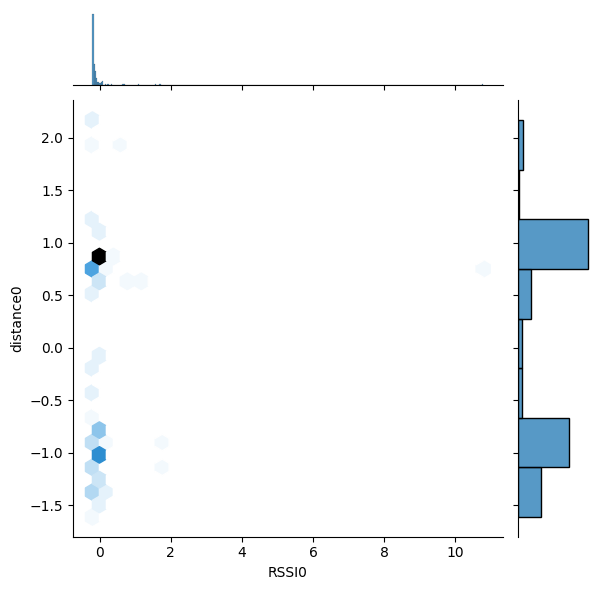

In [21]:
# Plot
sns.jointplot(x=atk_df['RSSI0'], y=atk_df['distance0'], kind='hex')

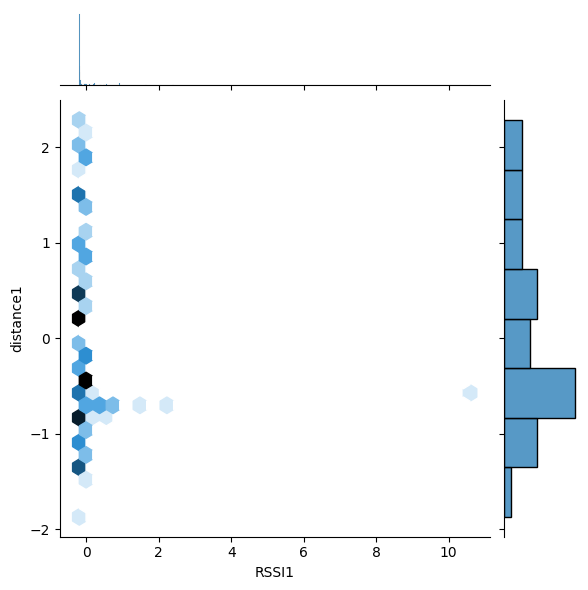

In [123]:
# Plot
sns.jointplot(x=atk_df['RSSI1'], y=atk_df['distance1'], kind='hex')

## Fit the MLP Model

### Load Model Params

In [450]:
initial_parameters = None
file = Config.output_path + Config.weights_file
if os.path.exists(file):
    npzfile = np.load(file)
    params = [npzfile[x] for x in npzfile]
    params = fl.common.ndarrays_to_parameters(params)
    initial_parameters = fl.common.parameters_to_ndarrays(params)
    print("Setting model params...")
    client.model.set_weights(initial_parameters)

Setting model params...


In [29]:
results = client.fit(
    parameters=None, # initial_parameters,
    config={
        "batch_size": Config.batch_size,
        "epochs": Config.epochs
    },
    verbose=1
)

Training...
Epoch 1/50
6203/6203 [==============================] - 9s 1ms/step - loss: 0.2926 - f1: 0.8995 - val_loss: 0.2710 - val_f1: 0.9055
Epoch 2/50
6203/6203 [==============================] - 9s 1ms/step - loss: 0.2931 - f1: 0.8991 - val_loss: 0.2739 - val_f1: 0.9041
Epoch 3/50
6203/6203 [==============================] - 9s 1ms/step - loss: 0.2922 - f1: 0.8992 - val_loss: 0.2725 - val_f1: 0.9052
Epoch 4/50
6203/6203 [==============================] - 9s 1ms/step - loss: 0.2920 - f1: 0.8993 - val_loss: 0.2731 - val_f1: 0.9044
Epoch 5/50
6203/6203 [==============================] - 9s 1ms/step - loss: 0.2918 - f1: 0.8992 - val_loss: 0.2748 - val_f1: 0.9055
Epoch 6/50
6203/6203 [==============================] - 9s 1ms/step - loss: 0.2911 - f1: 0.8999 - val_loss: 0.2733 - val_f1: 0.9041
Epoch 7/50
6203/6203 [==============================] - 9s 1ms/step - loss: 0.2910 - f1: 0.8996 - val_loss: 0.2791 - val_f1: 0.9027
Epoch 8/50
6203/6203 [==============================] - 9s 1ms/s

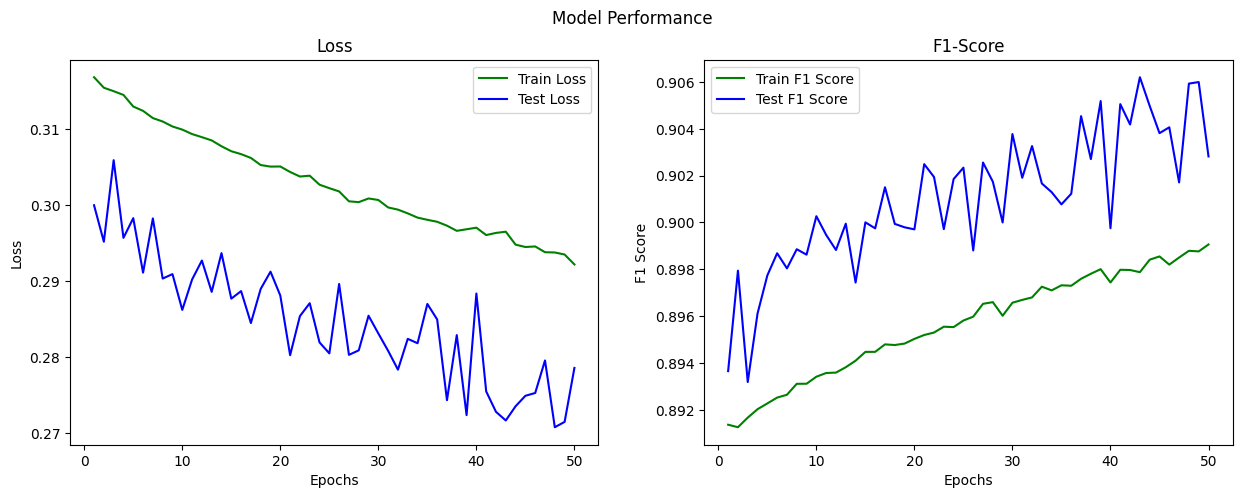

In [23]:
train_f1_score = client.history.history['f1']
test_f1_score = client.history.history['val_f1']
train_loss = client.history.history['loss']
test_loss = client.history.history['val_loss']
epochs = range(1, Config.epochs + 1)
loss, num_examples, metrics = results

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Model Performance')
fig.set_figwidth(15)
fig.set_figheight(5)

ax1.plot(epochs, train_loss, '-g', label="Train Loss")
ax1.plot(epochs, test_loss, '-b', label="Test Loss")
ax1.legend()
ax1.set(xlabel='Epochs', ylabel='Loss')
ax1.set_title('Loss')

ax2.plot(epochs, train_f1_score, '-g', label="Train F1 Score")
ax2.plot(epochs, test_f1_score, '-b', label="Test F1 Score")
ax2.legend()
ax2.set(xlabel='Epochs', ylabel='F1 Score')
ax2.set_title('F1-Score')

plt.show()

In [24]:
def plot_pr_roc_curves(probabilities: Any):
    n_classes = client.test_labels.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    precision = dict()
    recall = dict()
    pr_auc = dict()
        
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(client.test_labels[:, i], probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        precision[i], recall[i], _ = precision_recall_curve(client.test_labels[:, i], probabilities[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    # First aggregate all false positive rates
    all_precision = np.unique(np.concatenate([precision[i] for i in range(n_classes)]))
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    mean_recall = np.zeros_like(all_precision)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_recall += np.interp(all_precision, precision[i], recall[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes
    mean_recall /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    precision["macro"] = all_precision
    recall["macro"] = mean_recall
    pr_auc["macro"] = auc(recall["macro"], precision["macro"])

    lw = 2
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle('PR and ROC Curves - Multiclass')
    fig.set_figwidth(15)
    fig.set_figheight(5)

    colors = cycle(["b", "g", "r", "c", "m", "y"])
    
    # ROC Curve
    ax1.plot(
        fpr["macro"],
        tpr["macro"],
        label="Macro Avg (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
        alpha=0.5,        
    )
    for i, color in zip(range(n_classes), colors):
        label_classes = int(client.lb.classes_[i])
        ax1.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="Class {0} (area = {1:0.2f})".format(label_classes, roc_auc[i]),
            alpha=0.5
        )
    ax1.set_title(f"ROC Curve - {Config.feature} - {Config.label}")
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.legend()

    # PR curve
    ax2.plot(
        precision["macro"],
        recall["macro"],
        label="Macro Avg (area = {0:0.2f})".format(pr_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
        alpha=0.5,
    )
    for i, color in zip(range(n_classes), colors):
        label_classes = int(client.lb.classes_[i])
        ax2.plot(
            precision[i],
            recall[i],
            color=color,
            lw=lw,
            label="Class {0} (area = {1:0.2f})".format(label_classes, pr_auc[i]),
            alpha=0.5
        )
    ax2.set_title(f"PR Curve - {Config.feature} - {Config.label}")    
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.legend()
    
    plt.show()

6203/6203 [==============================] - 4s 568us/step


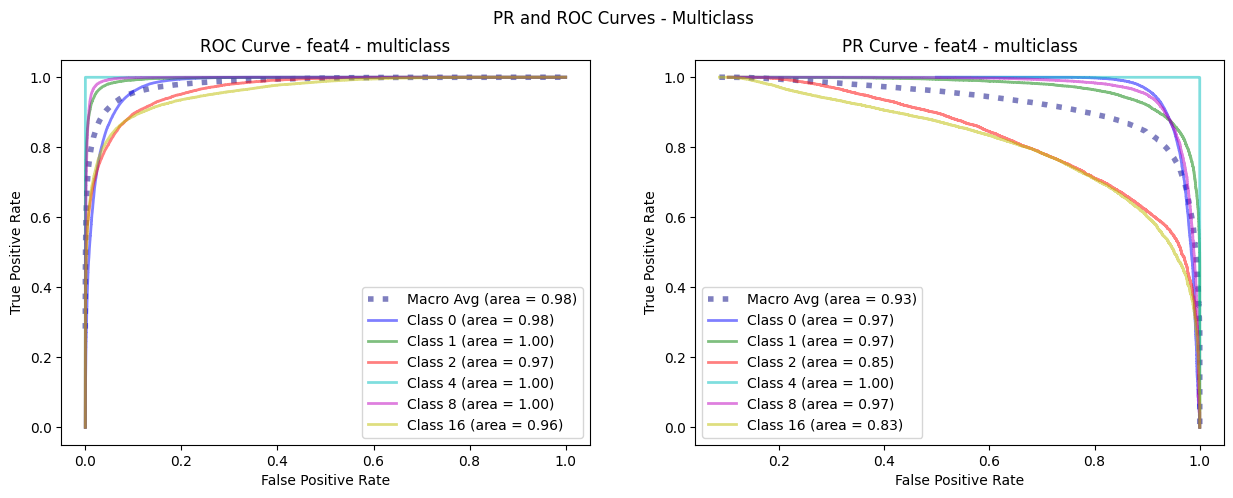

In [25]:
probabilities = client.model.predict(client.test_data)
inverse_target = client.lb.inverse_transform(client.test_labels)
prediction = None

if Config.label == 'multiclass':
    prediction = client.lb.inverse_transform(probabilities)
    # TODO: PLOT MULTICLASS 
    plot_pr_roc_curves(probabilities)
else:
    pos_label = 1 if Config.label == 'binary' else int(Config.label.split("_")[1])
    # Best threshold
    precision, recall, thresholds = precision_recall_curve(
        inverse_target,
        probabilities[:, 1],
        pos_label=pos_label
    )
    # convert to f score
    np.seterr(divide='ignore', invalid='ignore')
    fscore = (2 * precision * recall) / (precision + recall)
    np.nan_to_num(fscore, copy=False)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    print("-" * 70)
    
    prediction = np.where(np.array(probabilities[:, 1]) >= thresholds[ix], pos_label, 0)
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle('PR and ROC Curves')
    fig.set_figwidth(15)
    fig.set_figheight(5)

    # PR Curve
    PrecisionRecallDisplay.from_predictions(inverse_target, probabilities[:, 1], pos_label=pos_label, ax=ax1)
    no_skill = len(inverse_target[inverse_target == 1]) / len(inverse_target)
    ax1.plot([0, 1], [no_skill, no_skill], linestyle='--', color="grey", label='No Skill')
    ax1.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best threshold')
    ax1.set_title(f"PR Curve - {Config.feature} - {Config.label}")
    ax1.legend()

    # ROC curve
    RocCurveDisplay.from_predictions(inverse_target, probabilities[:, 1], pos_label=pos_label, ax=ax2)
    ax2.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--")
    ax2.set_title(f"ROC Curve - {Config.feature} - {Config.label}")
    
    plt.show()

### Classification Report

In [26]:
classlist = []
for cl in client.lb.classes_:
    classlist.append('class ' + str(int(cl)))

print(classification_report(inverse_target, prediction, target_names=classlist, digits=3, zero_division=0))
print("-" * 70)

              precision    recall  f1-score   support

     class 0      0.889     0.974     0.929     99043
     class 1      0.928     0.894     0.911     20652
     class 2      0.875     0.641     0.740     20391
     class 4      1.000     0.999     1.000     20698
     class 8      0.898     0.950     0.923     20551
    class 16      0.866     0.638     0.735     17153

    accuracy                          0.903    198488
   macro avg      0.909     0.849     0.873    198488
weighted avg      0.902     0.903     0.898    198488

----------------------------------------------------------------------


### Confusion Matrix

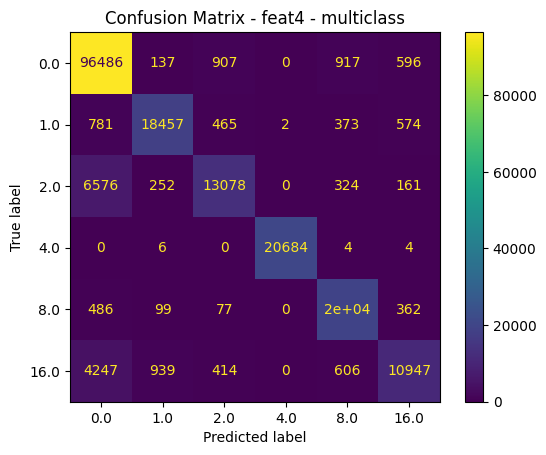

In [27]:
cm = confusion_matrix(inverse_target, prediction, labels=client.lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=client.lb.classes_)
disp.plot()
plt.title(f"Confusion Matrix - {Config.feature} - {Config.label}")
plt.show()

### Performance

In [28]:
name = Config.label + "-" + Config.model_type + "-" + Config.feature
if Config.label == 'multiclass':
    prscore = precision_score(inverse_target, prediction, average='macro', zero_division=0)
    rcscore = recall_score(inverse_target, prediction, average='macro', zero_division=0)
    f1score = f1_score(inverse_target, prediction, average='macro', zero_division=0)
    accscore = accuracy_score(inverse_target, prediction)
else:
    prscore = precision_score(inverse_target, prediction, pos_label=pos_label, zero_division=0)
    rcscore = recall_score(inverse_target, prediction, pos_label=pos_label, zero_division=0)
    f1score = f1_score(inverse_target, prediction, pos_label=pos_label, zero_division=0)
    accscore = accuracy_score(inverse_target, prediction)
data_performance = {name: [prscore, rcscore, f1score, accscore]}
df_performance = pd.DataFrame.from_dict(data_performance, orient='index', columns=["precision", "recall", "f1score", "accuracy"])
df_performance

,precision,recall,f1score,accuracy
multiclass-mlp-feat4,0.909226,0.849492,0.872977,0.90272
